## Tuning model parameters to match a firing rate

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.loader import DataLoader

import sys
sys.path.append("..")

from spiking_network.models import RectifiedLNP
from spiking_network.datasets import MexicanHatGenerator
from spiking_network.utils import calculate_firing_rate, calculate_isi

In this example we will show how to tune a model to a given firing rate. We will use the RectifiedLNP model,
but the same procedure can be applied to any other model. 

The RectifiedLNP model is taken from the paper
[Systematic errors in connectivity inferred from activity in strongly coupled recurrent circuits](https://www.biorxiv.org/content/10.1101/512053v1.full)
and in the paper it is hand-tuned to get an interspike interval of 16 ms. We will show how to do this automatically using snn-glm-simulator.

### Preparing the training data
We start by making some networks that we want to fit the model on. We will use 100 networks of 100 neurons each, with weights drawn
from a ring network with weights drawn from a mexican hat distribution.

In [2]:
# Create a dataset of random connectivity matrices to train on
n_neurons = 100
n_networks = 100
dataset = MexicanHatGenerator(100, a=1.0015, sigma_1=6.98, sigma_2=7.).generate_examples(n_networks)
train = dataset[:int(0.8*n_networks)]
test = dataset[int(0.8*n_networks):]

train_loader = DataLoader(train, batch_size=2, shuffle=True)
test_loader = DataLoader(test, batch_size=10, shuffle=True)

### The Rectified Linear-Nonlinear-Poisson model
In the `RectifiedLNP` model, neurons are subject to a uniform background input $b$ in addition to the recurrent synaptic input from neighbors, weighted by $r$. Spikes from neighboring neurons are filtered by an exponential decay with a time constant $\tau$. For each time step, spikes are sampled from a Poisson distribution after passing the input through a thresholded scaled rectifier.

$$g_i(t+1) = \sum_{j \in \mathcal{N}(i)} \mathbf{W}_{j, i} \cdot \mathbf{x}_j(t) + b$$
$$\mu_i(t+1) = \lambda_0 [g_i(t+1) - \theta]_+$$ 
$$ x_i(t+1) \sim \text{Pois}(\mu_i(t+1))$$

In [3]:
# Create a model to tune
model = RectifiedLNP(
    lambda_0 = 100.,
    theta = 1e-4,
    T=200,
    tau=10.,
    dt=0.1,
    r=0.0025,
    b=0.001
)

Let's see what kind of behaviour these parameters lead to by simulating the model on the test set for one second.

In [4]:
results = []
for data in test_loader:
    results.append(
        model.simulate(data, n_steps=1000, equilibration_steps=100)
    )
X = torch.cat(results, dim=0)

100%|██████████| 1000/1000 [00:30<00:00, 32.87it/s]


In [5]:
# Calculate firing rate and ISI
fr = calculate_firing_rate(X, dt=0.1)
isi = calculate_isi(X, dt=0.1)

print("Average firing rate: ", fr.item(), "Hz")
print("Average ISI: ", isi.item(), "ms")

Average firing rate:  751.8500366210938 Hz
Average ISI:  1.3300524950027466 ms


We see that there is way to much activity. The models are tuned using a target firing rate, so let's first convert the ISI of 16 ms to a firing rate.

In [6]:
target_fr = 1000 / 16 # 1 second / 16 ms = 62.5 Hz

In [7]:
for i, data in enumerate(train_loader):
    model.tune(data, firing_rate=target_fr, tunable_parameters=["theta"], n_steps=10, lr=1e-6, n_epochs=100)

Tuning... fr=62.76096:  32%|███▏      | 32/100 [00:03<00:07,  9.18it/s]


KeyboardInterrupt: 

Let's see how the model performs on the test set:

In [8]:
test_results=[]
for data in test_loader:
    test_results.append(
        model.simulate(data, n_steps=1000)
    )
X_test = torch.cat(test_results, dim=0)

100%|██████████| 1000/1000 [00:24<00:00, 40.39it/s]


In [9]:
print(calculate_firing_rate(X_test, dt=0.1).item())
print(calculate_isi(X_test, dt=0.1).item())

623.3450317382812
1.604248046875


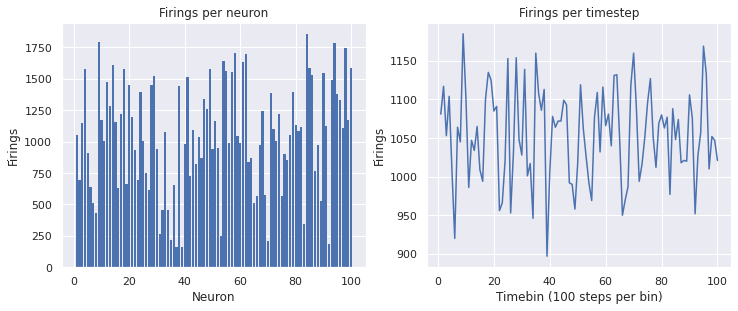

In [6]:
# Plot the results for the first simulation
visualize_spikes(results[0])

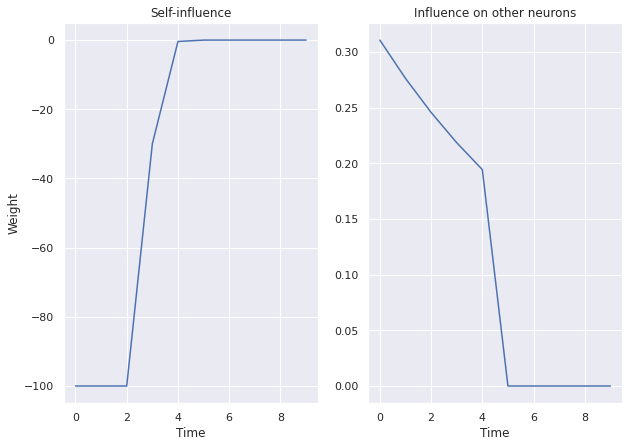

In [12]:
# Visualize the time dependence of the model
W = sparse_to_dense(model.connectivity_filter(w0_dataset[0].W0, w0_dataset[0].edge_index).detach(), w0_dataset[0].edge_index)
visualize_time_dependence(W)